## Task Description

Write a custom fused ReLU class for 2D tensors, that implements **vector addition and ReLU**, with the **forward** pass. Then write a fused ReLU Triton kernel for 2D tensors that performs the **vector addition and ReLU** with the **forward** pass and computes its matching **backward** pass. Verify that both implementations produce the same outputs and gradients on random inputs and write a benchmark test with 'triton.testing' to showcase the efficiency of Triton in comparison to Torch. And you should look into **PyTorch's JIT** to make your pytorch implementation more efficient.

## Code

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import triton.language as tl
import triton
import triton.testing

In [2]:
DEVICE = "cuda"

### 1. Implementation of the forward pass for the fused ReLU with PyTorch

In [3]:
class FusedAddReLU(nn.Module):
    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return F.relu(x + y)
torchModel = torch.jit.script(FusedAddReLU())

### 2. Implementation of the forward & backward pass for the fused ReLU with Triton

In [4]:
@triton.jit
def _add_relu_fwd(x_ptr,
               y_ptr,
               output_ptr,
               n_elements,
               BLOCK_SIZE: tl.constexpr,
               ):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)

    summed = x + y
    relued = tl.maximum(summed, 0.0)

    tl.store(output_ptr + offsets, relued, mask=mask)

@triton.jit
def _add_relu_bwd(O_ptr,
                  dO_ptr,
                  dx_ptr,
                  dy_ptr,
                  n_elements,
                  BLOCK_SIZE: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    O = tl.load(O_ptr + offsets, mask=mask)
    dO = tl.load(dO_ptr + offsets, mask=mask)

    relu_mask = O > 0
    dx = dO * relu_mask
    dy = dx

    tl.store(dx_ptr + offsets, dx, mask=mask)
    tl.store(dy_ptr + offsets, dy, mask=mask)

In [5]:
class TritonAddReLU(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
      x = x.to(device='cuda')
      y = y.to(device='cuda')

      O = torch.empty_like(x)
      n_elements = O.numel()

      grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
      _add_relu_fwd[grid](x, y, O, n_elements, BLOCK_SIZE=512)

      ctx.save_for_backward(O)

      return O

    @staticmethod
    def backward(ctx, dO):
        O, = ctx.saved_tensors

        assert dO.is_contiguous()

        dx = torch.empty_like(dO)
        dy = torch.empty_like(dO)

        n_elements = dO.numel()

        grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
        _add_relu_bwd[grid](O, dO, dx, dy, n_elements, BLOCK_SIZE=128)

        return dx, dy

tritonFn = TritonAddReLU.apply

### 3. Verify outputs & benchmark test

In [6]:
# Benchmark
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch (JIT)'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-relu-performance',
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torchModel(x,y), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: tritonFn(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

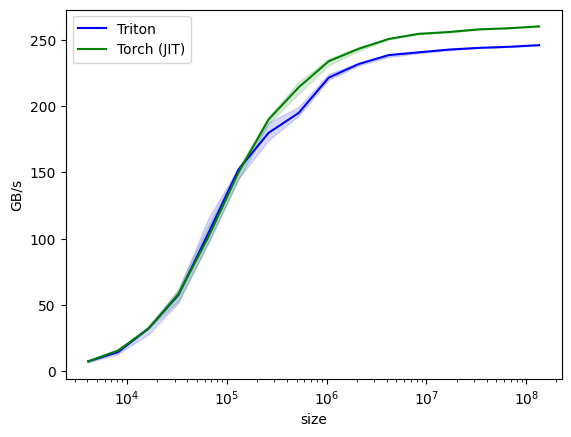

vector-add-relu-performance:
           size      Triton  Torch (JIT)
0        4096.0    7.331742     7.279621
1        8192.0   14.388759    15.593909
2       16384.0   31.999999    31.999999
3       32768.0   57.420561    57.962264
4       65536.0  104.135590   101.344331
5      131072.0  152.173381   150.082447
6      262144.0  179.879241   189.959427
7      524288.0  194.854311   214.169933
8     1048576.0  221.530139   233.917907
9     2097152.0  231.849058   243.364396
10    4194304.0  238.601945   250.775518
11    8388608.0  240.673893   254.622048
12   16777216.0  242.725927   255.999991
13   33554432.0  244.044067   258.007812
14   67108864.0  244.838275   258.865036
15  134217728.0  246.088031   260.258488


In [7]:
benchmark.run(print_data=True, show_plots=True)

In [8]:
# Verify Outputs
tensor_shape = (2048, 4096)
x_triton = torch.randn(tensor_shape, device=DEVICE, dtype=torch.float32, requires_grad=True)
y_triton = torch.randn(tensor_shape, device=DEVICE, dtype=torch.float32, requires_grad=True)

x_torch = x_triton.detach().clone().requires_grad_(True)
y_torch = y_triton.detach().clone().requires_grad_(True)

grad_output = torch.randn(tensor_shape, device=DEVICE, dtype=torch.float32)

# --- Run Triton Path ---
output_triton = tritonFn(x_triton, y_triton)
output_triton.backward(grad_output)
dx_triton = x_triton.grad
dy_triton = y_triton.grad

# --- Run PyTorch Path ---
output_torch = torchModel(x_torch, y_torch)
output_torch.backward(grad_output)
dx_torch = x_torch.grad
dy_torch = y_torch.grad

# Check forward pass
assert torch.allclose(output_triton, output_torch, atol=1e-6, rtol=1e-5)

# Check gradients
assert torch.allclose(dx_triton, dx_torch, atol=1e-6, rtol=1e-5)
assert torch.allclose(dy_triton, dy_torch, atol=1e-6, rtol=1e-5)